# Spectral Line Fitting: Outflow in Galaxies  Traced by Absorption Lines

## Outflows

In star-forming galaxies, stellar feedback, including stellar wind, radiation preseeure, photoionization, and supernova explosion, can drive outflowing gas,  both in ionized and neutral phase.

Outflows driven by stellar feedback hold clues about self-regulation of star formation, and also how optically thin channels are cleared through which ionizing photons are able escape to eventually ionize the universe at very high redshift (cosmic ionization).  

Illustration of outflows from Erb2015:
<img src="ZChen_data/outflow_erb15.png" width="400"/> 


Outflows indicate (fast) moving  ionized and neutral gas and therefore are frequently tarced by the following signatures in a galaxy spectrum:

#### Broad wing of emission lines.

Outflowing gas are moving, presumably, in every direction.
Therefore in the emission line profile, in addtion to a narrow component (Gaussian) which is intrinsic brodening caused by rotation or turbulence, there are broad wings result from the moving of ionized gas.

Example of outflow induced broadening of H$_\alpha$ line profile (Freeman+2019)
<img src="ZChen_data/outflow_freeman19_emission.png" width="300"/> 

#### Blueshifted low ionization absorption lines

Netrual gas between the central star formation site and us will often leave absorption lines in a spectrum.
Since the gas in between is approaching us, the absorption line is usually blueshifted.

Example for blueshifted absorption line (Erb2015)
<img src="ZChen_data/outflow_erb15_absorption.png" width="300"/> 


## This report

This is part of my on-going research to understand the star formation and stellar feedback in reionization-era galaxies, by studying their analogs in the local universe (with similar intense star formation activities and spectroscopic properties).

I will experiment with UV spectra for local extreme metal-poor galaxies (XMPs, believed to the aforementioned analogs) delivered by HST/COS (G160M) to find signatures of outflows imprinted in the absorption lines.

(UV spectra is of particular importance and is what you will get if you are to observe the highest-redshift galaxies with ground-based optical-NIR telescopes, or the upcoming JWST).

To ensure I am using publicly accessible data for this illustration and to avoid further complexity during the illustrarion, the analysis below are based on archival HST/COS G160M spectrum for J104457, a local XMP (HST proposal ID: 15465).

The method used here is to detect the blueshift of low ionization absorption lines.

The spectrum are in extremly-high resoltuion (R > 10,000) and after binning the spectra by six pixels the resoltuion in velocity is $\Delta v \sim 13\ {\rm km\ s}^{-1}$

### HST/COS: blueshift of low ionization lines with Gaussian profile fitting

What you wiil need: 

- systematic redshift, $z_{\rm sys}$ of the system determined from nebular emission (O III] 1660, 1666 doublet here)
- redshift of absorption lines, (blueshift actually, $z_{\rm abs}$, Si II 1627 here) 


How:
- to determine the line center of emission or absorption by fitting Gaussian profile
- achieved by **non-linear model (Gaussian) fitting to data with LevMarLSQFitter**

Let's start:

## Packages and functions used

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from astropy import constants as const
from astropy.modeling import models, fitting
from astropy import units as u
from astropy.io import fits 

from specutils.spectra import Spectrum1D,SpectralRegion
from specutils.fitting import fit_lines
from specutils.fitting import fit_generic_continuum

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### Read and bin spectrum

In [3]:
def bin_spec(wl,flux,err,len_bin=6):
    
    len_wl = len(wl)
#     nbin = len_wl//len_bin
    ndiscard = len_wl%len_bin
    
    wl = wl[:-ndiscard]
    flux = flux[:-ndiscard]
    err = err[:-ndiscard]
    
    wl = np.mean(wl.reshape(-1, len_bin), axis=1)
    flux = np.mean(flux.reshape(-1, len_bin), axis=1)
    err = np.sqrt(np.mean(err.reshape(-1, len_bin)**2, axis=1)/len_bin)

    return wl, flux, err

def read_cos(name,z_init,len_bin=6):
    path = 'ZChen_data/'
    tmp = fits.open(path+name+'.fits')
    wl = tmp[1].data['WAVELENGTH']
    flux = tmp[1].data['FLUX']
    err = tmp[1].data['ERROR']
    
    wl = np.concatenate([wl[1,:],wl[0,:]])
    flux = np.concatenate([flux[1,:],flux[0,:]]) 
    err = np.concatenate([err[1,:],err[0,:]])
    
    wl, flux, err = bin_spec(wl,flux,err,len_bin)
    
    # Normalize to feature-free region
    err = err / np.median(flux[(wl/(1+z_init) < 1652) & (wl/(1+z_init) > 1648)])
    flux = flux/ np.median(flux[(wl/(1+z_init) < 1652) & (wl/(1+z_init) > 1648)])

    return wl, flux, err


#### Inspect the spectrum

In [4]:
from matplotlib import gridspec


def specline_inspect(wl160,flux160,err160,zoiii,name):

    f = plt.figure(figsize=(18,5))
    
    ymax = np.max(flux160)*1.2

    gs_left = gridspec.GridSpec(1, 2,width_ratios=[1,2])

    ax1 = f.add_subplot(gs_left[0])
    ax2 = f.add_subplot(gs_left[1],sharey=ax1)
    # ax3 = f.add_subplot(gs_left[2],sharey=ax1)

    ax1.plot([1526.707,1526.707],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax1.text(1530.4,ymax*0.8,'Si II',fontsize=15)
    ax1.plot([1550.781,1550.781],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax1.plot([1548.204,1548.204],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax1.text(1552,ymax*0.8,'C IV]',fontsize=15)


    ax2.plot([1640.42,1640.42],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax2.text(1642,ymax*0.8,'He II',fontsize=15)
    ax2.plot([1660.809,1660.809],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax2.plot([1666.150,1666.150],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax2.text(1662,ymax*0.8,'O III]',fontsize=15)
    ax2.plot([1670.7874,1670.7874],[0,ymax],'k', dashes=[6, 4],lw=2)
    ax2.text(1672,ymax*0.8,'Al II',fontsize=15)

    # plot the same data on both axes
    ax1.plot(wl160/(1+zoiii),flux160,color='b',lw=2)
    ax1.fill_between(wl160/(1+zoiii),flux160-err160,flux160+err160,color='grey',alpha=0.4)
    ax2.plot(wl160/(1+zoiii),flux160,color='b',lw=2)
    ax2.fill_between(wl160/(1+zoiii),flux160-err160,flux160+err160,color='grey',alpha=0.4)
    
    ymax = np.max(flux160)*1.2
    ax1.set_xlim(1515,1560);ax1.set_ylim(0,ymax)
    ax2.set_xlim(1635,1675);ax2.set_ylim(0,ymax)
    ax1.text(1542,ymax*0.9,name,fontsize=15,color='green')


    ax1.tick_params(axis="both", labelsize=12) 
    ax2.tick_params(axis="both", labelsize=12) 

    # hide the spines
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    ax1.yaxis.tick_left()
    ax2.get_yaxis().set_visible(False)

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d/2,+d/2), (1-d,1+d), **kwargs)
    ax2.plot((-d/2,+d/2), (-d,+d), **kwargs)


    plt.subplots_adjust(wspace=0.08)

    f.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Normalized flux',fontsize=18)
    plt.xlabel(r'Rest wavelength [$\AA$]',fontsize=18)
    plt.show()
    plt.tight_layout()
    # f.savefig('%s_with_err.png'%names[i],dpi=300)

#### Pick up regions in spectrum you're interested in

In [5]:
def pick_region(wl,flux,err,zoiii,which='civ'):
    rest_wl = wl/(1+zoiii)
    if which == 'civ':
        sel = (rest_wl > 1535) & (rest_wl < 1565)
    elif which == 'siii':
        sel = (rest_wl > 1510) & (rest_wl < 1540)
    elif which == 'oiii':
        sel = (rest_wl > 1645) & (rest_wl < 1675)
    elif which == 'alii':
        sel = (rest_wl > 1655) & (rest_wl < 1685)
    elif which == 'heii':
        sel = (rest_wl > 1620) & (rest_wl < 1660)
    return rest_wl[sel], flux[sel], err[sel]


def fit_region_continuum(restwl,flux,which='civ',plot=True):
    spectrum = Spectrum1D(flux=flux*u.Unit('erg s-1 cm-2 A-1'), spectral_axis=restwl*u.AA)
    # Fit the continuum
    if which == 'civ':
        exclude_region = [SpectralRegion(1545*u.AA, 1555*u.AA)]
    elif which == 'siii':
        exclude_region = [SpectralRegion(1525*u.AA, 1528*u.AA)]
    elif which == 'oiii':
        exclude_region = [SpectralRegion(1658*u.AA, 1662*u.AA),SpectralRegion(1663*u.AA, 1668*u.AA)]
    elif which == 'alii':
        exclude_region = [SpectralRegion(1658*u.AA, 1662*u.AA),SpectralRegion(1663*u.AA, 1668*u.AA), \
                         SpectralRegion(1668*u.AA, 1672*u.AA)]
    elif which == 'heii':
        exclude_region = [SpectralRegion(1637*u.AA, 1643*u.AA)]
    
    g1_fit = fit_generic_continuum(spectrum,\
                                   exclude_regions=exclude_region)
    y_continuum_fitted = g1_fit(restwl*u.AA)
    if plot==True:
        plt.plot(restwl, flux)
        plt.plot(restwl, y_continuum_fitted)
        plt.title('Continuum Fitting')
        plt.grid(True)
    
    flux_normalized = flux - y_continuum_fitted.value
#     err_normalized = err / y_continuum_fitted.value
    return flux_normalized#, err_normalized

def plot_region(restwl, flux, err,which='civ'):
    plt.figure(figsize=(12,5))
    plt.plot(restwl,flux,color='b',lw=2)
    plt.fill_between(restwl,flux-err,flux+err,color='grey',alpha=0.4)
    
    if which == 'civ':
        xmin, xmax = 1545,1555
        sel = (restwl>xmin) & (restwl<xmax)
        ymax = np.max(flux[sel])*1.2
        plt.ylim(-1,ymax)
        plt.plot([1550.781,1550.781],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.plot([1548.204,1548.204],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.text(1552,ymax*0.8,'C IV',fontsize=15)
    elif which == 'siii':
        xmin, xmax = 1520,1530
        sel = (restwl>xmin) & (restwl<xmax)
        ymax = np.max(flux[sel])*1.2
        plt.ylim(-1,ymax)
        plt.plot([1526.707,1526.707],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.text(1522,ymax*0.8,'Si II',fontsize=15)
    elif which == 'oiii':
        xmin, xmax = 1655,1670
        sel = (restwl>xmin) & (restwl<xmax)
        ymax = np.max(flux[sel])*1.2
        plt.ylim(-1,ymax)
        plt.plot([1660.809,1660.809],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.plot([1666.150,1666.150],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.text(1662,ymax*0.8,'O III]',fontsize=15)
    elif which == 'alii':
        xmin, xmax = 1663,1678
        sel = (restwl>xmin) & (restwl<xmax)
        ymax = np.max(flux[sel])*1.2
        plt.ylim(-1,ymax)
        plt.plot([1670.7874,1670.7874],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.text(1669,ymax*0.8,'Al II',fontsize=15)
    elif which == 'heii':
        xmin, xmax = 1635,1645
        sel = (restwl>xmin) & (restwl<xmax)
        ymax = np.max(flux[sel])*1.2
        plt.ylim(-1,ymax)
        plt.plot([1640.42,1640.42],[-1,ymax],'k', dashes=[6, 4],lw=2)
        plt.text(1642,ymax*0.8,'He II',fontsize=15)
    
    plt.plot([xmin, xmax],[0,0],'k', dashes=[6, 4],lw=1)
    plt.xlim(xmin,xmax)
    plt.ylabel('Normalized flux',fontsize=18)
    plt.xlabel(r'Rest wavelength [$\AA$]',fontsize=18)
    plt.tick_params(axis="both", labelsize=12) 
    plt.show()
    plt.close()
    
def get_v(restwl_obs,wl_true):
    return (restwl_obs - wl_true)/wl_true * const.c.to(u.km/u.s).value

#### Fit double Gaussian to OIII] doublet emission

In [6]:
# 1550.781,1548.204
def fit_double_gaussian(restwl,flux,which='oiii',plot=True):
    
    if which == 'oiii':
        wl0 = 1660.809
        wl1 = 1666.150
        amp_factor = 2
        window = (restwl > 1658) & (restwl < 1668)
        
    amp0 = np.max(flux) 
    
    # emission
    g0_e = models.Gaussian1D(amplitude=amp0, mean = wl0, stddev=0.2)
    g1_e = models.Gaussian1D(amplitude=amp0*amp_factor, mean = wl1, stddev=0.2)
    
    def tie_wave_e(model):
        return model.mean_0 * wl1 / wl0
    g1_e.mean.tied = tie_wave_e
    
    g0_e.amplitude.min = 0
    g1_e.amplitude.min = 0
        
    
    line_init = g0_e + g1_e 
    
    fit = fitting.LevMarLSQFitter()
    line_fit = fit(line_init, restwl[window], flux[window])
    
    flux_fit = line_fit(restwl) 
    
    amps = [line_fit.amplitude_0,line_fit.amplitude_1]
    means = [line_fit.mean_0, line_fit.mean_1]
    stds = [line_fit.stddev_0, line_fit.stddev_1]
    
    if plot == True:
        plt.figure(figsize=(12,5))
        plt.step(restwl,flux,color='k',lw=2,where='mid')
    #     plt.fill_between(restwl,flux-err,flux+err,color='grey',alpha=0.4)
        plt.plot(restwl, flux_fit, color='r',lw=2)
        ymax = np.max(flux)*1.2
        if which == 'oiii':
            xmin, xmax = 1655,1670
            plt.plot([1660.809,1660.809],[-1,ymax],'k', dashes=[6, 4],lw=2)
            plt.plot([1666.150,1666.150],[-1,ymax],'k', dashes=[6, 4],lw=2)
            plt.text(1662,ymax*0.8,'O III]',fontsize=15)
    
        plt.plot([xmin, xmax],[0,0],'k', dashes=[6, 4],lw=1)
        plt.ylabel('Normalized flux',fontsize=18)
        plt.xlabel(r'Rest wavelength [$\AA$]',fontsize=18)
        plt.tick_params(axis="both", labelsize=12) 
        plt.xlim(xmin,xmax)
        plt.ylim(-2,ymax)
        plt.show()
        plt.close()
    
        print(line_fit)
    return flux_fit, amps, means, stds

#### Fit single gaussian to absorption lines

In [7]:
# 1550.781,1548.204
def fit_single_gaussian(restwl,flux,which='siii',plot=True):
    
    if which == 'siii':
        wl0 = 1526.707
        window = (restwl > 1524) & (restwl < 1528)
    elif which == 'alii':
        wl0 = 1670.7874
        window = (restwl > 1668) & (restwl < 1672)
        
    amp0 = np.min(flux) 
    
    # absorption
    g0_a = models.Gaussian1D(amplitude=amp0, mean = wl0, stddev=0.2)
    
    g0_a.amplitude.max = 0
        
    
    line_init = g0_a
    
    fit = fitting.LevMarLSQFitter()
    line_fit = fit(line_init, restwl[window], flux[window])
    
    flux_fit = line_fit(restwl) 
    
    amps = line_fit.amplitude
    means = line_fit.mean
    stds = line_fit.stddev
    
#     for i in range(len(amps)):
#     line_fit = gaussian(restwl, amps[2], means[2], stds[2]) + gaussian(restwl, amps[3], means[3], stds[3]) + 1
#     plt.plot(restwl, line_a, color='b',lw=2,ls='--')
    
    if plot == True:
        plt.figure(figsize=(12,5))
        plt.step(restwl,flux,color='k',lw=2,where='mid')
    #     plt.fill_between(restwl,flux-err,flux+err,color='grey',alpha=0.4)
        plt.plot(restwl, flux_fit, color='r',lw=2)
        ymax = np.max(flux)*1.2
        if which == 'siii':
            xmin, xmax = 1520,1535
            plt.plot([1526.707,1526.707],[-1,ymax],'k', dashes=[6, 4],lw=2)
            plt.text(1530.4,4,'Si II',fontsize=15)
        elif which == 'alii':
            xmin, xmax = 1663,1678
            plt.plot([1670.7874,1670.7874],[-1,ymax],'k', dashes=[6, 4],lw=2)
            plt.text(1669,4,'Al II',fontsize=15)

        plt.plot([xmin, xmax],[0,0],'k', dashes=[6, 4],lw=1)
        plt.ylabel('Normalized flux',fontsize=18)
        plt.xlabel(r'Rest wavelength [$\AA$]',fontsize=18)
        plt.tick_params(axis="both", labelsize=12) 
        plt.xlim(xmin,xmax)
        plt.ylim(-5,ymax)
        plt.show()
        plt.close()
    
        print(line_fit)
    return flux_fit, amps, means, stds

#### Measure $z_{sys}$ using the OIII] doublet emission, and estimate the uncertainties by perturb the flux 100 time according its error spectrum

In [8]:
from numpy.random import normal 

from multiprocessing import Pool
from functools import partial


def measure_zoiii_multi(flux,restwl=None,z_init=None,plot=False,smooth=False):
    flux = fit_region_continuum(restwl,flux,which='oiii',plot=plot)
    if smooth:
        flux = savgol_filter(flux,13,2)
    _,_,means,_ = fit_double_gaussian(restwl, flux, which='oiii',plot=plot)
    wl1 = 1666.150
    zoiii = means[1]*(1+z_init) / wl1 - 1
    return zoiii
    

def measure_zoiii(wl,flux,err,z_oiii,npet=100,plot=False,smooth=False):
    restwl, flux, err = pick_region(wl,flux,err,z_oiii,which='oiii')
    flux_p = normal(flux,scale=err,size=[npet,len(flux)])
    
    pool = Pool(20)
    zoiii = pool.map(partial(measure_zoiii_multi,restwl=restwl,z_init=z_oiii,plot=plot,smooth=smooth),flux_p)
    pool.close()
    zoiii = np.array(zoiii)
    if plot:
        plt.figure(figsize=(7,4))
        plt.hist(zoiii,histtype='step',color='b')
        plt.show()
        plt.close()
        print(np.median(zoiii),np.percentile(zoiii,16),np.percentile(zoiii,84))
    return zoiii

#### Fit single gaussian to Si II 1527 absorption lines

In [9]:
from numpy.random import normal 

from multiprocessing import Pool
from functools import partial

from scipy.signal import savgol_filter


def measure_vsi_multi(zoiii,wl=None,flux=None,err=None,method='Gaussian',plot=False,smooth=False):
    restwl, flux, err = pick_region(wl,flux,err,zoiii,which='siii')
    flux_p = normal(flux,scale=err,size=len(flux))
    flux = fit_region_continuum(restwl,flux_p,which='siii',plot=plot)
    
    if smooth:
        flux = savgol_filter(flux,13,2)
    if method == 'Gaussian':
        _, _, mean, _ = fit_single_gaussian(restwl,flux,which='siii',plot=plot)
        vsi = get_v(mean,1526.707)
        return vsi
        

def measure_vsi(wl,flux,err,zoiii,npet=100,plot=False,method='Gaussian',smooth=False):
    pool = Pool(20)
    vsi = pool.map(partial(measure_vsi_multi,wl=wl,flux=flux,err=err,method=method,plot=plot,smooth=smooth),zoiii[:npet])
    pool.close()
    vsi = np.array(vsi)
    plt.figure(figsize=(7,4))
    plt.hist(vsi,histtype='step',color='b')
    plt.show()
    plt.close()
    print(np.median(vsi),np.percentile(vsi,16),np.percentile(vsi,84))
    return vsi

#### Show line profile

In [10]:
wl_lines = [1526.707, 1548.204, 1550.781, 1640.42, 1660.809, 1666.150, 1670.7874]
lines = ['siii','civ', 'civ50', 'heii', 'oiii60', 'oiii', 'alii']
line_labels = ['SiII 1527','CIV 1548', 'CIV 1550', 'HeII 1640', 'OIII 1660', 'OIII 1666', 'AlII1671']
colors = ['k','r','orange','dodgerblue','cyan','b','grey']
lss = [':','-',(0, (6, 4)), ':','-',(0, (6, 4)) ]

def plot_vel(wl,flux,err,zmed,include,c='r',legend=True,plot_err=True, axi_label=False):
    for line_ in include:
        i = lines.index(line_)
        
        if line_ == 'civ50':
            line_ = 'civ'
        if line_ == 'oiii60':
            line_ = 'oiii'
        
        restwl,flux0,err0 = pick_region(wl,flux,err,zmed,which=line_)
        flux0 = fit_region_continuum(restwl,flux0,which=line_,plot=False)
        vel_wl = const.c.to(u.km/u.s).value * (restwl-wl_lines[i])/wl_lines[i]
        flux_norm = flux0/np.max(np.abs(flux0[(vel_wl<300)&(vel_wl>-300)]))
        err_norm = err0/np.max(np.abs(flux0[(vel_wl<300)&(vel_wl>-300)]))
            
        if c is not None:
            color_ = c
            ls_ = lss[i]
        else:
            color_ = colors[i]
            ls_ = '-'
        
        if plot_err:
            plt.fill_between(vel_wl,flux_norm-err_norm, flux_norm+err_norm,color=color_,alpha=0.15)
            
        if legend:
            plt.plot(vel_wl,flux_norm,color=color_,lw=2,label=line_labels[i],ls=ls_)
        else:
            plt.plot(vel_wl,flux_norm,color=color_,lw=2,ls=ls_)
            
        if axi_label:
            plt.xlim(-300,300)
            plt.ylim(-1.2,1.2)
            plt.plot([-300,300],[0,0],'k--',lw=1)
            plt.plot([0,0],[-1.2,1.2],'k--',lw=1)

            plt.legend(loc='best',fontsize=18)
            plt.xlabel('velocity [km/s]', fontsize=20)
            plt.ylabel('Normalized Flux', fontsize=20)

## Fit it

In [11]:
# Read data
name = 'J104457'
# initila redshift was used to normalize the spectrum in reading data (to feature-free region) 
# and to pick up regions of interest
# can be determined from optical spectrum or any reasonable initial guess, as long as you pick up the right region
z_init = 0.013
wl, flux, err = read_cos(name,z_init)

(array([ 3., 12., 22., 18., 23., 13.,  3.,  2.,  1.,  2.,  0.,  0.,  0.,
         0.,  1.]),
 array([0.01285345, 0.01285846, 0.01286347, 0.01286849, 0.0128735 ,
        0.01287851, 0.01288352, 0.01288853, 0.01289354, 0.01289855,
        0.01290356, 0.01290857, 0.01291358, 0.01291859, 0.0129236 ,
        0.01292861]),
 <a list of 1 Patch objects>)

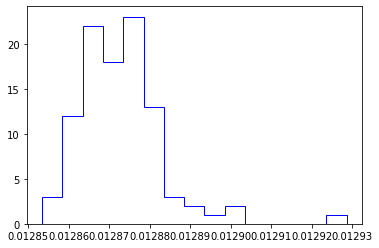

In [12]:
# Measure systematic redshift using the OIII] doublet emission (fixing their relative wavelength)
# and estimate the uncertainties by perturb the flux 100 time according its error spectrum
zoiii = measure_zoiii(wl,flux,err,z_init)
plt.hist(zoiii, bins='fd',histtype='step',color='b')

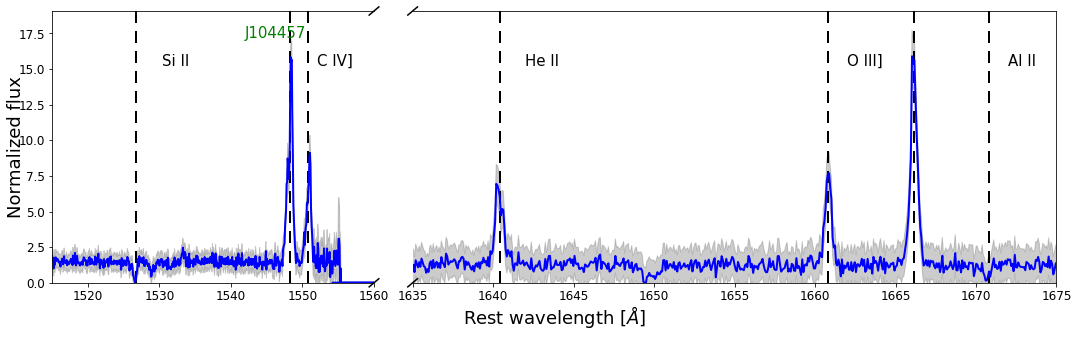

<Figure size 432x288 with 0 Axes>

In [13]:
# Have a look at the rest-frame spectrum
zmed = np.median(zoiii)
specline_inspect(wl,flux,err,zmed,name)

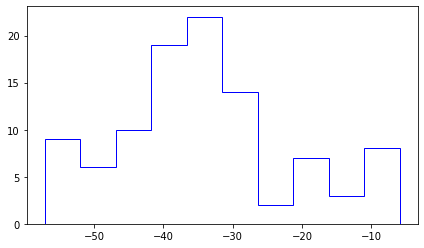

-34.31004612609529 -44.12620219766761 -20.672083461887492


In [14]:
# Measure blueshift of Si II 1527
vsi = measure_vsi(wl,flux,err,zoiii)

## Results:

Blueshifted velocity:

median: -39 km/s

16% - 84% uncertainty: -49 $\sim$ -3 km/s

**weak outflow?**

Note that this is a **low-mass** system (stellar mass $M_\ast \sim 6.8 M_\odot$)

#### Have a look at the line profile

Text(0.5, 1.0, 'J104457')

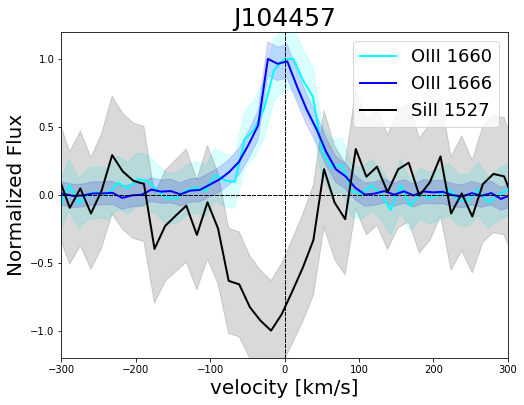

In [15]:
plt.figure(figsize=(8,6))
plot_vel(wl,flux,err,zmed,include=['oiii60','oiii','siii'], c=None,plot_err=True,axi_label=True)
plt.title('J104457',fontsize=25)